# LSTM for Time-Series
### ADAM, Batch size 200, Sequence Length 50
This notebook is the resultant of three different cross validation experiments

#### Header
This part will use TENSORFLOW backend for KERAS API


In [1]:
# !pip install tensorflow==1.8.0
# !pip install keras==2.2.0
!pip install pandas
!pip install matplotlib
!pip install sklearn

tensorflow-gpu 1.9.0 has requirement setuptools<=39.1.0, but you'll have setuptools 39.2.0 which is incompatible.


tensorflow-gpu 1.9.0 has requirement setuptools<=39.1.0, but you'll have setuptools 39.2.0 which is incompatible.


tensorflow-gpu 1.9.0 has requirement setuptools<=39.1.0, but you'll have setuptools 39.2.0 which is incompatible.


#### General libs

In [2]:
import os
import time
import pickle
import warnings

#### Data structures

In [3]:
import numpy as np
import pandas as pd
from numpy import newaxis

#### Visualization

In [4]:
import matplotlib.pyplot as plt

#### ML libs

In [5]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

#### Deep learning libs

In [6]:


import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LeakyReLU
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import TensorBoard, ReduceLROnPlateau, Callback, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


#### Hide warnings

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

#### Callback class to clear the state at the end of epoch

In [8]:
class Model_state_reset(Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()

In [9]:
reset_state = Model_state_reset()

#### Data Loader
This module will load the data and return it with train test split

In [10]:
def configure_data(seq_len, data, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    #np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

#### Data normalisers

In [11]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [12]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

#### Model builder
3 layers are there
* 1 Input = Contains feature of sequence length, in this use case
* 1 hidden = maps sequnce length numbered featires to hidden unit feature space
* 1 output = Fully connected to work with linear activation for regression type action

In [13]:
 def build_model(layers, batch_size, set_weights = False, weights = np.array([])):
    model = Sequential()

    model.add(LSTM(
        batch_input_shape=(batch_size, layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True,stateful=True))
    #model.add(Dropout(0.2))
    model.add(Activation("relu"))

    model.add(LSTM(
        layers[2],
        return_sequences=False,stateful=True))
    #model.add(Dropout(0.2))
    lrelu = LeakyReLU(alpha=0.01)
    model.add(Activation("relu"))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    if set_weights:
        model.set_weights(weights)
    
    start = time.time()
    model.compile(loss="mse", optimizer = adam)
    print("> Compilation Time : ", time.time() - start)
    return model

#### Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time

In [14]:
# def predict_point_by_point(model, data, batch_size):
#     predicted = model.predict(data,batch_size = batch_size)
#     predicted = np.reshape(predicted, (predicted.size,))
#     return predicted

In [15]:
def predict_point_by_point(model, data):
    predicted = model.predict(data, batch_size=1)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

#### Multi point prediction

In [16]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in list(range(len(data))):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1, predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, window_size-1, predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

#### Single point plotting

In [17]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=[15,10])
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

#### Multiple points prediction plotting

In [18]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=[15,10])
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

#### Input size calculator as per batch

In [19]:
def size_calc(n,m):
    return n - n %m

#### Variable and constant initialisation 

In [20]:
global_start_time = time.time()
epochs  = 100
seq_len = 50
batch_size = 200
layer_arch = [1, 50,100, 1]

print('> Loading data... ')

> Loading data... 


#### Data loading

In [21]:
with open('ts1.pkl', 'rb') as handle:
    collected_op_type_one = pickle.load(handle)

#### Converting to data frame

In [22]:
ts1_df = pd.DataFrame(collected_op_type_one)

#### Converting the values to numeric

In [23]:
ts1_df['values'] = ts1_df['values'].apply(lambda a:int(a))

In [24]:
len(ts1_df['timestamp'].unique())

143843

#### Total number of timestamps

In [25]:
ts1_df.count()

timestamp    143938
values       143938
dtype: int64

#### Converting to 1-D array

In [26]:
input_array = np.array(ts1_df['values'])

#### Taking differences of consecutive time stamps.

In [27]:
input_array = difference(dataset= input_array)

#### Converting list to numpy arrays

In [28]:
input_array = np.array(input_array)

#### Reshaping to be in (N,1)

In [29]:
input_array = np.reshape(input_array,(-1,1))

In [30]:
input_array.shape

(143937, 1)

#### Scale the data to be in Minimum and Maximum ranges

In [31]:
scale = MinMaxScaler(feature_range=(-1,1))

In [32]:
input_array = scale.fit_transform(input_array)

#### Get Custom train and test split, in supervised learning format

In [33]:
X_train, y_train, X_test, y_test = configure_data(seq_len, input_array, False)

In [34]:
print('X_Train:',len(X_train), 'Y_Train:',len(y_train))
print('X_Test:',len(X_test),'Y_test:',len(y_test))

X_Train: 129497 Y_Train: 129497
X_Test: 14389 Y_test: 14389


In [35]:
print('X_Train shape:',X_train.shape, 'Y_Train shape:',y_train.shape)
print('X_Test shape:', X_test.shape,'Y_test shape:', y_test.shape)

X_Train shape: (129497, 50, 1) Y_Train shape: (129497, 1)
X_Test shape: (14389, 50, 1) Y_test shape: (14389, 1)


#### input data size calculation

In [36]:
required_input_size = size_calc(len(X_train), batch_size)

In [37]:
len(X_train[:required_input_size])

129400

In [38]:
required_validation_size = size_calc(len(X_test), batch_size)

#### Model check point for best model only to pin point the best one in all epochs

In [39]:
checkpoint = ModelCheckpoint(os.getcwd() + "\\checkpoint\\weights_adam_non_dropout_200_50.hdf5", monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only = True, mode='min')


In [40]:
reset_state.on_epoch_end

<bound method Model_state_reset.on_epoch_end of <__main__.Model_state_reset object at 0x0000019350EE7F28>>

In [41]:
checkpoint.on_epoch_end

<bound method ModelCheckpoint.on_epoch_end of <keras.callbacks.ModelCheckpoint object at 0x0000019354DEC3C8>>

#### Build the model

In [42]:
train_start_time = time.time()

In [43]:

model = build_model(layers= layer_arch, batch_size=batch_size, set_weights=False)
model.summary()

print("\n\n\n")

tensorboard = TensorBoard(log_dir = os.getcwd() + '\\' + 'logs_cv_result\\{}'.format(time.time()), )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1) 

history = model.fit(X_train[:required_input_size], y_train[:required_input_size], batch_size=batch_size, 
                nb_epoch= epochs, 
                validation_data=(X_test[:required_validation_size], y_test[:required_validation_size]), 
                verbose=1, 
                shuffle = False, callbacks=[tensorboard,reduce_lr, checkpoint, reset_state])

print("\n\n End of learning with")

> Compilation Time :  0.053858041763305664
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (200, 50, 50)             10400     
_________________________________________________________________
activation_1 (Activation)    (200, 50, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (200, 100)                60400     
_________________________________________________________________
activation_2 (Activation)    (200, 100)                0         
_________________________________________________________________
dense_1 (Dense)              (200, 1)                  101       
_________________________________________________________________
activation_3 (Activation)    (200, 1)                  0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_____________________________


Epoch 00034: val_loss did not improve from 0.00118
Epoch 35/100
129400/129400 [==============================] - 172s 1ms/step - loss: 8.9390e-04 - val_loss: 0.0012

Epoch 00035: val_loss did not improve from 0.00118
Epoch 36/100
129400/129400 [==============================] - 172s 1ms/step - loss: 8.6346e-04 - val_loss: 0.0012

Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00036: val_loss did not improve from 0.00118
Epoch 37/100
129400/129400 [==============================] - 172s 1ms/step - loss: 8.7138e-04 - val_loss: 0.0012

Epoch 00037: val_loss improved from 0.00118 to 0.00117, saving model to F:\Repository\temp\checkpoint\weights_adam_non_dropout_200_50.hdf5
Epoch 38/100
129400/129400 [==============================] - 172s 1ms/step - loss: 8.7072e-04 - val_loss: 0.0012

Epoch 00038: val_loss did not improve from 0.00117
Epoch 39/100
129400/129400 [==============================] - 172s 1ms/step - loss: 8.5110e-04 - val_loss: 0.0012

Ep

129400/129400 [==============================] - 175s 1ms/step - loss: 7.1141e-04 - val_loss: 0.0012

Epoch 00079: val_loss did not improve from 0.00117
Epoch 80/100
129400/129400 [==============================] - 180s 1ms/step - loss: 7.0200e-04 - val_loss: 0.0012

Epoch 00080: val_loss did not improve from 0.00117
Epoch 81/100
129400/129400 [==============================] - 182s 1ms/step - loss: 6.9701e-04 - val_loss: 0.0012

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0020589112071320416.

Epoch 00081: val_loss did not improve from 0.00117
Epoch 82/100
129400/129400 [==============================] - 189s 1ms/step - loss: 6.9867e-04 - val_loss: 0.0013

Epoch 00082: val_loss did not improve from 0.00117
Epoch 83/100
129400/129400 [==============================] - 179s 1ms/step - loss: 6.9422e-04 - val_loss: 0.0013

Epoch 00083: val_loss did not improve from 0.00117
Epoch 84/100
129400/129400 [==============================] - 196s 2ms/step - loss: 6.9336e-04 - val_l

In [44]:
print('Training duration (s) : ', (time.time() - train_start_time)/60,'minutes')

Training duration (s) :  292.7682223598162 minutes


In [45]:
print('Training duration (s) : ', (time.time() - train_start_time)/60,'minutes')

Training duration (s) :  292.77563629547757 minutes


In [46]:
print('Training duration (s) : ', (time.time() - train_start_time)/60,'minutes')

Training duration (s) :  292.779142387708 minutes


#### Plot of training history

In [47]:
history.history.keys()

dict_keys(['val_loss', 'loss', 'lr'])

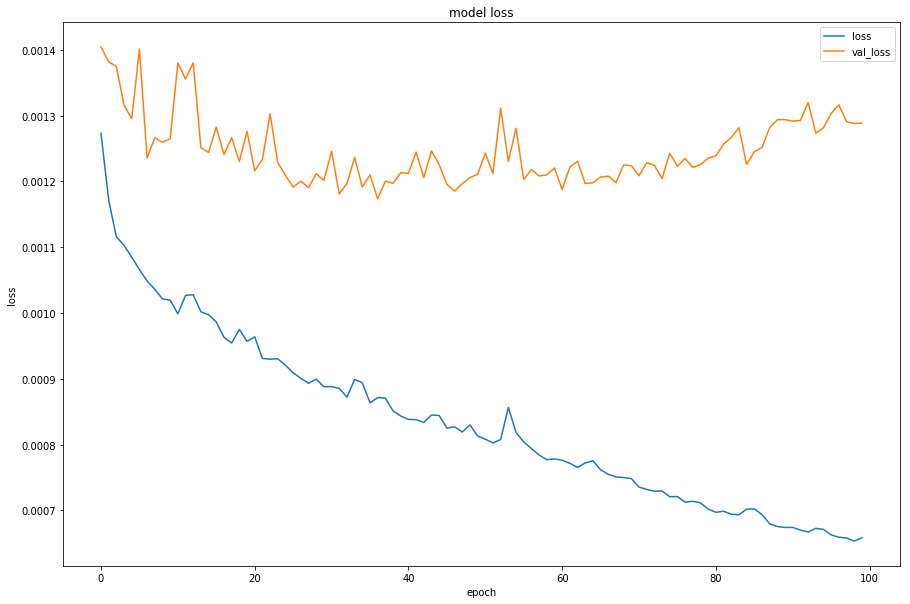

In [48]:
plt.figure(figsize=(15,10)) 

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['loss', 'val_loss'], loc='best') 

# Prediction Net
#### Create new model for online learning

In [49]:
new_model = build_model(layers=layer_arch, batch_size = 1, set_weights=False)
#prediction_array[optimizer_unit] = predict_point_by_point(new_model, X_test)
    

> Compilation Time :  0.03600883483886719


#### Load the best model weights

In [50]:
new_model.load_weights('./checkpoint/weights_adam_non_dropout_200_50.hdf5')

In [51]:
prediction_array = predict_point_by_point(new_model, X_test)

In [52]:
plt.close()

### Plotting
plot predictions together

In [53]:
window_size = 400

In [54]:
X_test.shape

(14389, 50, 1)


========== Prediction plot for limited Time units


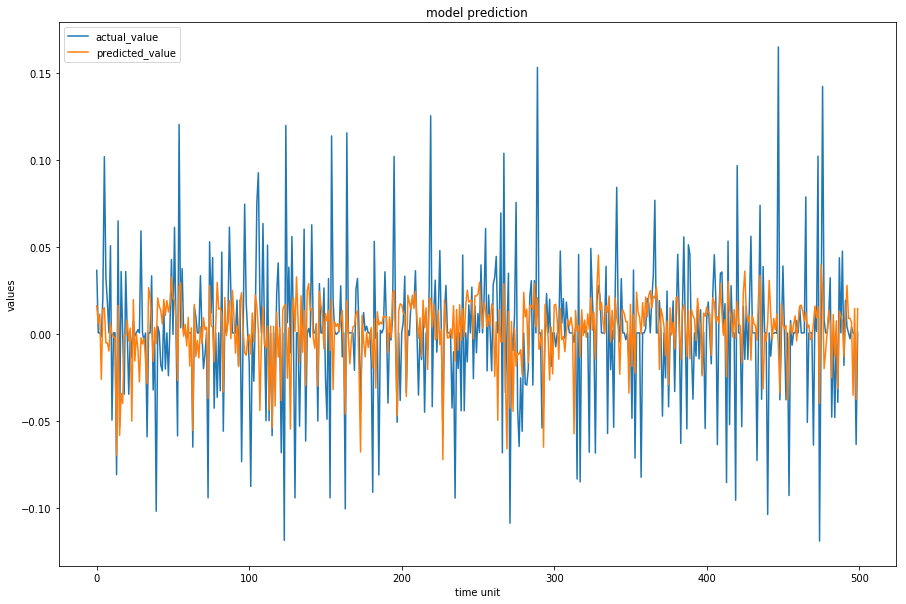

In [72]:

print("\n========== Prediction plot for limited Time units")
plt.close()
plt.figure(figsize=(15,10))
plt.plot(y_test[:window_size])

plt.plot(prediction_array[:window_size]) 
plt.title('model prediction') 
plt.ylabel('values') 
plt.xlabel('time unit') 
plt.legend(['actual_value', 'predicted_value'], loc='best')
plt.plot();
plt.pause(0.05)

In [56]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in list(range(len(data))):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        #print(curr_frame)
        #print(predicted[-1])
        #print(window_size-1)
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1, predicted[-1], axis=0)
    return predicted

In [57]:
prediction_array_full = predict_sequence_full(new_model, X_test, 50)


========== Prediction plot for limited Time units


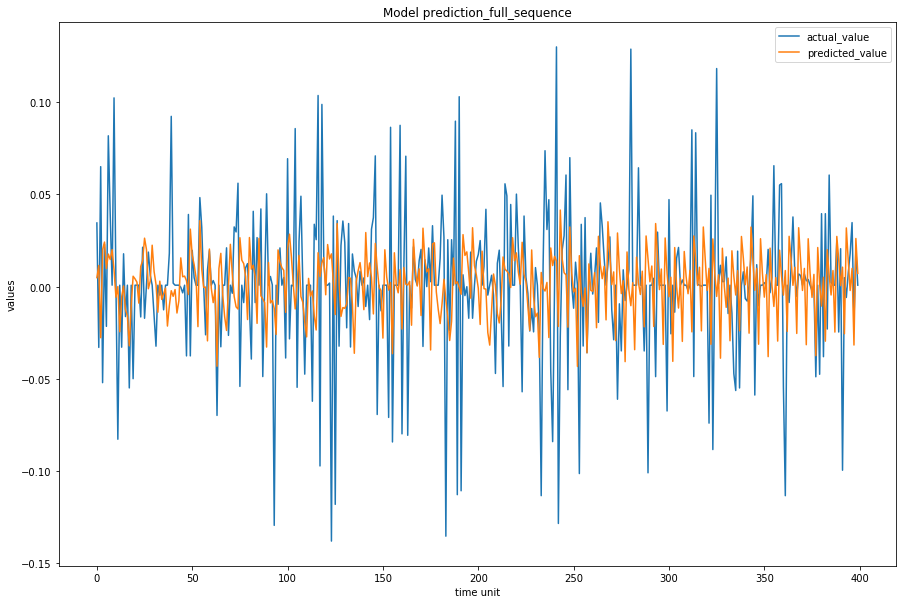

In [71]:

print("\n========== Prediction plot for limited Time units")
plt.close()
plt.figure(figsize=(15,10))
plt.plot(y_test[:window_size])

plt.plot(prediction_array_full[:window_size]) 
plt.title('Model prediction_full_sequence') 
plt.ylabel('values') 
plt.xlabel('time unit') 
plt.legend(['actual_value', 'predicted_value'], loc='best')
plt.plot();
plt.pause(0.05)

In [59]:
#prediction_array_multiple = predict_sequences_multiple(new_model, X_test, 50, 400)

In [60]:
#plot_results_multiple(predicted_data=prediction_array_multiple, true_data=X_test,prediction_len=400)


========== Prediction plot for limited Time units


NameError: name 'prediction_array_multiple' is not defined

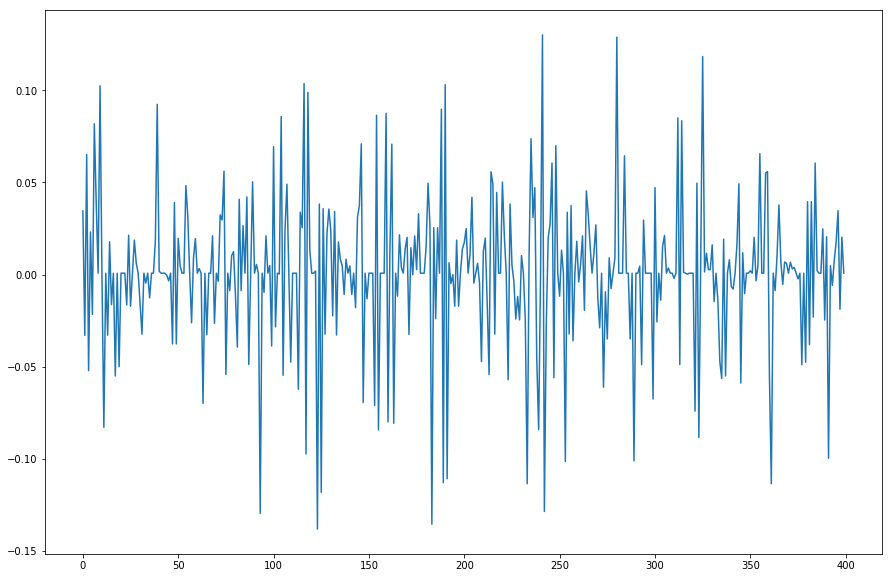

In [61]:

print("\n========== Prediction plot for limited Time units")
plt.close()
plt.figure(figsize=(15,10))
plt.plot(y_test[:window_size])

plt.plot(prediction_array_multiple[:window_size]) 
plt.title('Model prediction_full_sequence') 
plt.ylabel('values') 
plt.xlabel('time unit') 
plt.legend(['actual_value', 'predicted_value'], loc='best')
plt.plot();
plt.pause(0.05)

#### RMSE

In [62]:
y_test.shape

(14389, 1)

In [65]:
y_test_reshaped = np.reshape(y_test,(y_test.shape[0],))

print("\nRMSE:")
print(np.sqrt(metrics.mean_squared_error(y_test_reshaped, prediction_array)))
print("\nMAE:")
print(metrics.mean_absolute_error(y_test_reshaped, prediction_array))

print("=======================")


RMSE:
0.03496633245950107

MAE:
0.02347913074821112
